This script was developed by Ye et al. and published alongside the manuscript: 

*Benchmarking Metagenomics Tools for Taxonomic Classification*  DOI:https://doi.org/10.1016/j.cell.2019.07.010

Simon H. Ye, Katherine J. Siddle, Daniel J. Park, Pardis C. Sabeti

Code was downloaded from: https://github.com/yesimon/metax_bakeoff_2019

The original code was used to generate comparable benchmarking metrics to overlay IDseq
results on benchmark results for other taxonomic classification tools.
Any modifications (to assist with inputs/outputs) is documented with "IDseq EDIT".

In [1]:
import collections
from collections import OrderedDict
import functools
import os
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
import scipy.cluster
from scipy.spatial.distance import pdist, euclidean, cityblock, squareform
import sklearn.metrics
import yaml

import ncbitax

plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['font.size'] = 9
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.constrained_layout.h_pad'] = 0.15
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [6.85, 6.85]
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['boxplot.medianprops.color'] = 'k'
plt.rcParams['boxplot.showfliers'] = False

cm = plt.get_cmap('tab10')
cb_colors = [cm.colors[0], cm.colors[1], cm.colors[3]]
cm = plt.get_cmap('tab20')
plt.set_cmap(cm)

seq_color_index = list(range(0, 20, 2)) + list(range(1, 20, 2))
tab20_cycle = np.array([cm(1.*i/20) for i in seq_color_index])

In [2]:
df_orig = pd.read_csv('compiled_reports.tsv', sep='\t', low_memory=False) 

# ## IDseq EDIT === ADD the IDseq results to the results dataframe
idseq_df = pd.read_csv('../../data/idseq/cell-reports-benchmarking-metagenomics-tools_reports_v3.13/idseq_combined_results.tsv', sep='\t', low_memory=False)
df = pd.concat([df_orig, idseq_df])
df.reset_index(inplace=True)
# ==== 

ranks = ['species', 'genus', 'family']
for rank in ranks:
    colname = '{}_abundance'.format(rank)
    df[colname] = np.nan


df['taxid'] = df['taxid'].fillna(-1).astype(np.int32)
df.fillna({'database': 'default'}, inplace=True)

read_stats = pd.read_csv('read_counts.tsv', sep='\t', names=['sample', 'reads'])
read_stats = read_stats.set_index('sample')

rank_abundances_df = pd.read_csv('rank_abundances.tsv', sep='\t', names=['sample', 'classifier', 'database', 'rank', 'abundance'])


In [3]:
def calc_rank_abundance(df, rank='species', all_taxa=False):
    idx = df['rank'] == rank

    rank_sum = df.loc[idx, 'cum_abundance'].sum()
    colname = '{}_abundance'.format(rank)

    if all_taxa:
        df.loc[idx, colname] = df.loc[idx, 'cum_abundance'] / rank_sum
    else:
        df.loc[:, colname] = df.loc[:, 'cum_abundance'] / rank_sum

    return df
df[df['classrank'].isin(['all', 'species'])] = df[df['classrank'].isin(['all', 'species'])].groupby(['sample', 'classifier', 'database']).apply(calc_rank_abundance)
df[df['classrank'].isin(['all', 'genus'])] = df[df['classrank'].isin(['all', 'genus'])].groupby(['sample', 'classifier', 'database']).apply(functools.partial(calc_rank_abundance, rank='genus'))


In [4]:
# cami_truths = {
#     'goldstandard_low_1': 'RL_S001__insert_270',
#     'goldstandard_medium_1': 'RM2_S001__insert_270',
#     'goldstandard_medium_2': 'RM2_S002__insert_270',
#     'goldstandard_high_1': 'RH_S001__insert_270',
#     'goldstandard_high_2': 'RH_S002__insert_270',
#     'goldstandard_high_3': 'RH_S003__insert_270',
#     'goldstandard_high_4': 'RH_S004__insert_270',
#     'goldstandard_high_5': 'RH_S005__insert_270',
# }
# cami_df = pd.DataFrame(columns=['taxid', 'rank', 'name', 'abundance', 'sample'])
# for fn, sample in cami_truths.items():
#     cf = pd.read_csv('cami/{}.profile'.format(fn), sep='\t', skiprows=4)
#     cf = cf.rename(columns={'@@TAXID': 'taxid', 'RANK': 'rank', 'TAXPATH': 'taxpath', 'PERCENTAGE': 'raw_abundance'})
#     cf['taxid'] = cf['taxid'].apply(np.floor).astype(int)#.astype(np.int32)
#     cf['name'] = cf['TAXPATHSN'].str.split('|').str[-1]
#     cf['sample'] = sample
#     cf['abundance'] = cf.groupby(['rank'])['raw_abundance'].transform(lambda x: x/x.sum())
#     cami_df = cami_df.append(cf[cf['rank'].isin(['species', 'genus', 'family'])][['taxid', 'rank', 'name', 'abundance', 'sample']])
# cami_df['taxid'] = cami_df.taxid.astype(int)

# c = pd.read_csv('cami_truth.tsv', sep='\t', names=['sample', 'taxid', 'num_reads'])
# def norm_abund(x):
#     csum = x[~x['taxid'].isin([32644,  45202])]
#     x['abundance'] = x['num_reads'] / x['num_reads'].sum()
#     return x#[~x['taxid'].isin([32644,  45202])]

# z = pd.merge(c, cami_df, on=['sample', 'taxid']).groupby(['sample', 'rank']).apply(norm_abund)
# z = z[~z['taxid'].isin([32644,  45202])]
# # z.to_csv('cami_denormed.tsv', sep='\t', index=False)

In [5]:
# Load the truth abundance dataframes
# immsa_df = pd.read_excel('Dataset_descriptions.xlsx')
# def load_atcc_config(fn, sample):
#     conf = yaml.safe_load(open(fn))
#     taxons = []

#     genus_sum = collections.defaultdict(float)
#     genus_names = {}
#     for k, d in conf.items():
#         taxons.append({
#             'abundance': d['abundance'],
#             'rank': 'subspecies',
#             'taxid': k,
#             'name': d['name'],
#         })
#         taxons.append({
#             'abundance': d['abundance'],
#             'rank': 'species',
#             'taxid': d['species_id'],
#             'name': d['species_name'],
#         })
#         genus_names[d['genus_id']] = d['genus_name']
#         genus_sum[d['genus_id']] += d['abundance']
        
#     # Fix genus sums for multiple species under common genus
#     for taxid, name in genus_names.items():
#         taxons.append({
#             'abundance': genus_sum[taxid],
#             'rank': 'genus',
#             'taxid': taxid,
#             'name': name,
#         })
#     odf = pd.DataFrame(taxons) 
#     odf['sample'] = sample
#     return odf
                                         
# atce = load_atcc_config('atcc_even.yaml', 'atcc_even') 
# atcs = load_atcc_config('atcc_staggered.yaml', 'atcc_staggered') 


In [6]:
atce = pd.read_csv('atcc_even.tsv', sep='\t')
atcs = pd.read_csv('atcc_staggered.tsv', sep='\t')
cami_df = pd.read_csv('cami_denormed.tsv', sep='\t')

truth = collections.defaultdict(list)
def load_truth(truth, rank='species'):

    for ts in os.listdir('truth_sets/{}'.format(rank)):
        if ts.endswith('_abundances.txt'):
            continue
        if not ts.endswith('_TRUTH.txt'):
            continue
        sn = ts.replace('_TRUTH.txt', '')
        abund_col = 'abundance'
        with open(join('truth_sets', rank, ts), 'rt') as f:
            total_abund = None
            abunds = []
            for line in f:
                parts = line.strip().split('\t')
                taxid, abund, _, lrank, name = parts
                taxid = int(taxid)
                abund = float(abund)
                abunds.append({'sample': sn, abund_col: abund, 'name': name, 'taxid': taxid})
            abund_sum = sum([abund[abund_col] for abund in abunds])
            for abund in abunds:
                abund[abund_col] /= abund_sum
                truth[rank].append(abund)

rank_dfs = []
for rank in ['species', 'genus', 'subspecies']:
    load_truth(truth, rank=rank)
    tdf = pd.DataFrame(truth[rank])
    tdf['rank'] = rank
    rank_dfs.append(tdf)
#rank_dfs.append(vr_numreads) ## KK EDIT
truth_df = pd.concat(rank_dfs, sort=True)

real_dfs = []
for sample in ['DNA1', 'DNA2', 'RNA1', 'RNA2']:
    tmp_df = atce.copy()
    tmp_df['sample'] = sample
    real_dfs.append(tmp_df)

truth_df = pd.concat([truth_df, atce, atcs] + real_dfs + [cami_df], sort=False)
truth_df = truth_df.set_index(['rank', 'sample']).sort_index()
del truth_df['num_reads']

unamb_samples = [x for x in set(df['sample']) if x.startswith('UnAmbiguouslyMapped')]
truth_samples = unamb_samples + ['atcc_even', 'atcc_staggered']
truth_samples = set(truth_samples)
truth_samples.remove('UnAmbiguouslyMapped_ds.frankengenome.mix')
truth_samples.remove('UnAmbiguouslyMapped_ds.frankengenome')

cami_samples = [x for x in set(df['sample']) if x.endswith('270')]

In [7]:
# Get the formal names of classifiers
classifiers = collections.OrderedDict([
    ('bracken', 'Bracken'),
    ('centrifuge', 'Centrifuge'), 
    ('clark', 'CLARK'),
    ('clark_s', 'CLARK-S'),
    ('diamond', 'DIAMOND'), 
    ('gottcha', 'GOTTCHA'), 
    ('kaiju', 'Kaiju'), 
    ('karp', 'karp'), 
    ('kraken', 'Kraken'), 
    ('kraken2', 'Kraken2'), 
    ('krakenhll', 'KrakenUniq'),
    ('kslam', 'k-SLAM'), 
    ('megablast', 'MegaBLAST'), 
    ('metaothello', 'metaOthello'),
    ('metaphlan2', 'MetaPhlAn2'), 
    ('mmseqs2', 'MMseqs2'),
    ('motus2', 'mOTUs2'),
    ('pathseq', 'PathSeq'),
    ('prophyle', 'prophyle'), 
    ('taxmaps', 'taxMaps'),
    ('idseq_nt', 'IDseq NT'), ## IDseq EDIT
    ('idseq_nr', 'IDseq NR'),  ## IDseq EDIT
    ('idseq_ntnr_conc', 'IDseq NT NR Concordant'),  ## IDseq EDIT
    ('idseq_ntnr_conc_stringent', 'IDseq NT NR Concordant Stringent')
])

# Get the 'default', 'refseqc' sets of databases
cdb = df[['classifier', 'database']].drop_duplicates()
refseqc_tups = list(cdb[cdb['database'] == 'refseqc'].itertuples(index=False))
refseqc_dbs = ['refseqc']

default = cdb[cdb['database'] != 'refseqc']
default = default.drop(default[default['database'] == 'mini'].index)
default_tups = list(default.itertuples(index=False))
default_dbs = list(default['database'].drop_duplicates())

main_classifiers = classifiers.copy()
for c in ['karp', 'gottcha']:
    main_classifiers.pop(c)
refseqc_classifiers = classifiers.copy()
for c in ['gottcha', 'karp', 'pathseq', 'metaphlan2', 'metaothello', 'motus2']:
    refseqc_classifiers.pop(c)
    
classifier_group_order = collections.defaultdict(int)
classifier_group_order['metaphlan2'] = 2
classifier_group_order['motus2'] = 2
for c in ['kaiju', 'diamond', 'mmseqs2']:
    classifier_group_order[c] = 1
for c, c_capname in classifiers.items():
    classifier_group_order[c_capname] = classifier_group_order[c]

In [8]:
def filter_df(df, rank='species', classifier='kraken', sample='DNA1', dbs=None,
              classranks=None, copy=True):
    '''
    Filter df by a column attributes, returns a view
    '''

    if dbs is None:
        dbs = default_dbs
    if classranks is None:
        classranks = ['species', 'all']
    idx = df['classrank'].isin(classranks)
    if classifier:
        idx = idx & (df['classifier'] == classifier)
    if sample:
        idx = idx & (df['sample'] == sample)
    if rank:
        idx = idx & (df['rank'] == rank)
    if dbs:
        idx = idx & (df['database'].isin(dbs))
    return df.loc[idx]


def adjusted_pr(y_true, y_score):
    prec, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score)
    maxes = collections.defaultdict(float)
    for r, p in zip(recall, prec):
        maxes[r] = max(maxes[r], p)
    new_p = []
    for r, p in zip(recall, prec):
        new_p.append(maxes[r])
    prec = new_p
    if thresholds[0] == 0:
        prec[0] = 0
        recall[0] = recall[1]
        recall = np.insert(recall, 0, 1)
        prec = np.insert(prec, 0, 0)
    aupr = sklearn.metrics.auc(recall, prec)
    y_pred = y_score.fillna(0).map(np.ceil).astype(int)
    p, r, f, _ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='binary')
    return (prec, recall, thresholds, p, r, f, aupr)

## Adjusted PR without fixing per-recall maxes.
# def adjusted_pr(y_true, y_score):
#     prec, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score)
#     if thresholds[0] == 0:
#         prec[0] = 0
#         recall[0] = recall[1]
#     aupr = sklearn.metrics.auc(recall, prec)
#     y_pred = y_score.fillna(0).map(np.ceil).astype(int)
#     p, r, f, _ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='binary')
#     return (prec, recall, thresholds, p, r, f, aupr)''

def sample_truth_df(truth_df, sample, rank='species'):
    tdf = truth_df.loc[rank, sample].copy()
    tdf = tdf.set_index('taxid')
    return tdf


def pr_curve(classifier='kraken', sample='atcc_even',
             ax=None, crank='species', dbs=None, fillbetween=False,
             title=None, axislabels=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.85, 4))
    s = g.loc[(g['classifier'] == classifier) & (g['sample'] == sample) &
                  (g['database'].isin(default_dbs)) & (g['crank'] == crank), 'pr']
    try:
        stats = s.iloc[0]
    except:
        print(classifier, crank, sample, dbs)
        return
    prec, recall, thresholds, p, r, f, aupr = stats
    handles = ax.plot(recall, prec, linewidth=1, alpha=0.9, label=classifiers[classifier])
    if fillbetween:
        ax.fill_between(recall, prec, alpha=0.5)
    title = title or '{} Precision-Recall curve: AUPR={:0.2f}'.format(classifier, aupr)
    ax.set(ylim=[0.0, 1.05], xlim=[0.0, 1.0])
    if axislabels:
        ax.set(xlabel='Recall', ylabel='Precision')
    if title:
        ax.set_title(title)
    return handles[0]

In [9]:
# Generate cartesian product of all classifiers and databases for truth df merging
r = truth_df.reset_index()
r['taxid'] = r['taxid'].astype(str)
d = cdb.copy()
d['key'] = 1
r['key'] = 1
r = d.merge(r, on='key', how='outer').drop('key', axis=1)

# Merge all rows with truth df at once for efficiency
adf = df.copy()
adf.loc[~(adf['taxid'].isnull()), 'taxid'] = pd.to_numeric(adf['taxid'], errors='coerce').dropna().astype(int).astype(str)
adf.loc[adf['taxid'].isnull(), 'taxid'] = adf['name']
jj = pd.DataFrame()
rank = 'species'
for classranks in [ ['species', 'all'], ['genus', 'all']]:
    rank = classranks[0]
    cols = ['sample', 'classifier', 'database', 'taxid', 'name', '{}_abundance'.format(rank)]
    j = adf[(adf['rank'] == rank) & (adf['classrank'].isin(classranks))][cols].merge(r[r['rank'] == rank], on=['sample', 'taxid', 'classifier', 'database'], suffixes=('', '_y'), how='outer')#[cols]
    j['ytrue'] = j['abundance'].fillna(0).map(np.ceil).astype(int)
    rankcol = '{}_abundance'.format(rank)
    y_score = j[rankcol].fillna(0)
    j['yscore'] = y_score
    j['crank'] = rank
    jj = jj.append(j[cols + ['ytrue', 'yscore', 'crank']])
g = jj.groupby(['sample', 'classifier', 'database', 'crank']).apply(lambda x: adjusted_pr(x.ytrue, x.yscore))# j[j['sample'] == 'atcc_even']
g = g.reset_index().rename(columns={0: 'pr'})
g['aupr'] = g['pr'].str[-1]
g['p'] = g['pr'].str[3]
g['r'] = g['pr'].str[4]
g['f'] = g['pr'].str[5]

/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samp

/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


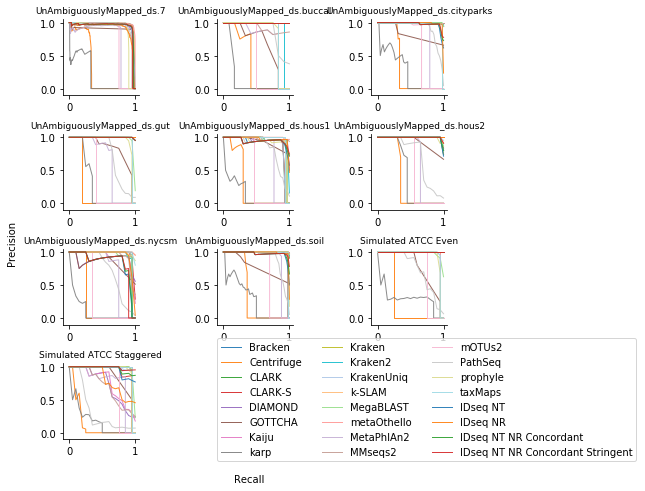

In [10]:
# P-R curve for all classifiers on one plot
sample_names = {s:s for s in set(df['sample'])}
sample_names['hg38'] = 'Simulated Hg38 DNA'
sample_names['atcc_even'] = 'Simulated ATCC Even'
sample_names['atcc_staggered'] = 'Simulated ATCC Staggered'
sample_names['DNA1'] = 'In-Vitro ATCC Even DNA 1'
sample_names['DNA2'] = 'In-Vitro ATCC Even DNA 2'
sample_names['RNA1'] = 'In-Vitro ATCC Even RNA 1'
sample_names['RNA2'] = 'In-Vitro ATCC Even RNA 2'
sample_names['NTC'] = 'In-Vitro NTC (Water Control)'


fig, axs = plt.subplots(4, 3, figsize=(6.85, 6.85), constrained_layout=False)
for sample, ax in zip(sorted(truth_samples), axs.flat):
    ax.set_prop_cycle(color=tab20_cycle)
    handles = []
    for classifier in classifiers:
        handles.append(pr_curve(classifier=classifier, sample=sample, crank='species', dbs=default_dbs,
                                ax=ax, axislabels=False, title=sample_names[sample]))
    ax.set_aspect('equal')
    ax.set(ylim=(-0.1, 1.05), xlim=(-0.1, 1.05))
    ax.set_title(ax.get_title(), fontsize=9)

x0 = axs[0,1].get_position().x0
x1 = axs[0,2].get_position().x1
y = axs[3,0].get_position()

axs[3,1].set_axis_off()
axs[3,2].set_axis_off()

fig.text(0.5, 0.02, "Recall", ha="center", va="center")
fig.text(0.02, 0.5, "Precision", ha="center", va="center", rotation=90)

leg = plt.figlegend(labels=[classifiers[c] for c in classifiers], handles=handles, loc='lower left', ncol=3,
              bbox_to_anchor=(x0, 0.05, x1 - x0, y.y1 - y.y0))
fig.tight_layout()
fig.subplots_adjust(bottom=0.1, left=0.1)
fig.savefig('svg/all_truth.pr_curve.svg'.format(sample))
fig.savefig('pdf/all_truth.pr_curve.pdf'.format(sample))


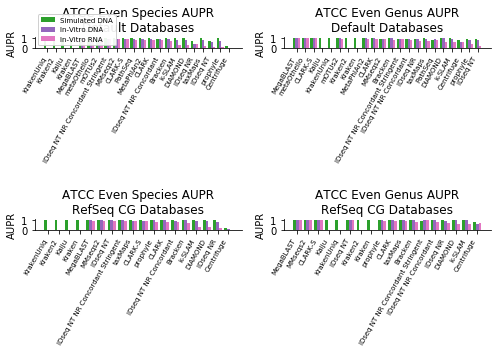

In [11]:
def plot_samples_aupr(samples, title, ax=ax, plot_classifiers=main_classifiers, dbs=None,
                      rank='species', crank='species', label=False, ylabel='AUPR', colors=cb_colors):
    plot_classifiers = np.array(list(plot_classifiers.keys()))
    dim = len(samples)
    n = len(plot_classifiers)
    n_range = np.arange(n)
    width = 0.8
    lim = (dim - 1) * (width / 2)
    offsets = np.linspace(-lim, lim, dim)
    label_names = {
        'atcc_even': 'Simulated DNA',
        'DNA1': 'In-Vitro DNA',
        'RNA1': 'In-Vitro RNA',
        'viral_refseqc': 'Viral Genomes',
    }

    cols = []
    for i, sample in enumerate(samples):
        aupr = g.loc[(g['classifier'].isin(plot_classifiers)) & (g['sample'] == sample) &
                     (g['database'].isin(default_dbs)) & (g['crank'] == crank), 'pr'].str[-1]
        cols.append(aupr)
    cols = np.stack(cols, axis=1)
    auprs = pd.DataFrame(cols, columns=samples).fillna(0.001)
    auprs['hmean'] = scipy.stats.hmean(np.ma.masked_where(auprs == 0, auprs), axis=1)
    ind = np.argsort(auprs['hmean'] * -1)

    for i, sample in enumerate(samples):

        ax.bar(n_range*dim + offsets[i], auprs.loc[ind, sample], color=colors[i], label=label_names[sample] if label else None)

    ax.set_xticks(n_range*dim)
    ax.set_xticklabels((classifiers[c] for c in plot_classifiers[ind]), rotation=60, fontsize=7, ha='right')
    ax.set(title=title, ylabel=ylabel)
    
fig, axs = plt.subplots(2, 2, figsize=(6.85, 5))
colors = tab20_cycle[np.array([2, 4, 6])]

plot_samples_aupr(['atcc_even', 'DNA1', 'RNA1'], 'ATCC Even Species AUPR\nDefault Databases', ax=axs[0, 0], label=True, colors=colors)
axs[0, 0].legend(loc='lower left', framealpha=0.92, fontsize=7)

plot_samples_aupr(['atcc_even', 'DNA1', 'RNA1'], 'ATCC Even Species AUPR\nRefSeq CG Databases', ax=axs[1, 0], dbs=refseqc_dbs, plot_classifiers=refseqc_classifiers, colors=colors)
plot_samples_aupr(['atcc_even', 'DNA1', 'RNA1'], 'ATCC Even Genus AUPR\nDefault Databases', ax=axs[0, 1], rank='genus', crank='genus', colors=colors)
plot_samples_aupr(['atcc_even', 'DNA1', 'RNA1'], 'ATCC Even Genus AUPR\nRefSeq CG Databases', ax=axs[1, 1], 
                  rank='genus', crank='genus', dbs=refseqc_dbs, plot_classifiers=refseqc_classifiers, colors=colors);

fig.savefig('pdf/atcc_aupr.pdf')
fig.savefig('svg/atcc_aupr.svg')

In [12]:
cols = ['sample', 'classifier', 'database', 'p', 'r', 'f', 'aupr']
aucs = g.loc[g['crank'] == 'species', cols]
aucg = g.loc[g['crank'] == 'genus', cols]
aucf = g.loc[g['crank'] == 'family', cols]

im = aucs[aucs['sample'].isin(truth_samples)]
im_d = im[im['database'].isin(default_dbs)]
img_d = aucg[(aucg['sample'].isin(truth_samples)) & (aucg['database'].isin(default_dbs))]
im_r = im[im['database'].isin(refseqc_dbs)]
img_r = aucg[(aucg['sample'].isin(truth_samples)) & (aucg['database'].isin(refseqc_dbs))]

cami = aucs[aucs['sample'].isin(cami_samples)]
cami_d = cami[cami['database'].isin(default_dbs)]
camig_d = aucg[(aucg['sample'].isin(cami_samples)) & (aucg['database'].isin(default_dbs))]
cami_r = cami[cami['database'].isin(refseqc_dbs)]
camig_r = aucg[(aucg['sample'].isin(cami_samples)) & (aucg['database'].isin(refseqc_dbs))]

camif_d = aucf[(aucf['sample'].isin(cami_samples)) & (aucf['database'].isin(default_dbs))]
camif_r = aucf[(aucf['sample'].isin(cami_samples)) & (aucf['database'].isin(refseqc_dbs))]


In [13]:
## IDseq EDIT
im_d.pivot(index='sample', columns='classifier')['aupr'].to_csv('../../data/output_aupr.csv')
im_d.pivot(index='sample', columns='classifier')['p'].to_csv('../../data/output_precision.csv')
im_d.pivot(index='sample', columns='classifier')['r'].to_csv('../../data/output_recall.csv')
im_d.pivot(index='sample', columns='classifier')['f'].to_csv('../../data/output_f1.csv')

**Data output for offline plotting - possible STOPPING point** 

The remaining code is relevant, but plots for the idseq-benchmark-manuscript are done in other notebooks.

------- 

In [14]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


def n_boxplot(arrays, title, labels=None, ax=None, fig=None, xlim=None, ylim=None, 
              legend=True, legend_loc='best', bbox_to_anchor=None, 
              colors=None, vlines=None, ylabel=None,
              sort_order='alphabetical'):
    '''
    Array of dict of x (category) to list of y (points in a boxplot) values.
    '''
    if colors is None:
        colors = cb_colors
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2.5*len(arrays)))
        
    vlines = vlines if vlines is not None else []            
    n_arrays = len(arrays)
    xlabels = arrays[0].keys()

    n = len(xlabels)
    
    bp_array = []
    
    lim = (n_arrays - 1) * 0.4
    offsets = np.linspace(-lim, lim, n_arrays)

    for a, offset in zip(arrays, offsets):
        bp_array.append(ax.boxplot(a.values(), positions=np.array(range(n))*n_arrays+offset, sym='', widths=0.6, manage_xticks=False))

    def plot_values(ys, offset, color):
        for i, y in enumerate(ys):
            # Add some random "jitter" to the x-axis
            x = np.random.normal(i*n_arrays+offset, 0.04, size=len(y))
            ax.plot(x, y, '.', color=color, markeredgewidth=0.3, alpha=0.4)

    for a, offset, color in zip(arrays, offsets, colors):
        plot_values(a.values(), offset, color)
    for bp, color in zip(bp_array, colors):
        set_box_color(bp, color) 
    
    # Draw empty lines and use them to create a legend
    handles = []
    for label, color in zip(labels, colors):
        handles.append(ax.plot([], c=color, label=label)[0])
    if legend:
        ax.legend(handles=handles, loc=legend_loc, bbox_to_anchor=bbox_to_anchor)
        
    for x in vlines:
        ax.axvline((x + 0.5) * (n_arrays), linestyle='--', color='k', linewidth=0.5)
    ax.margins(x=0.02)
    ax.set_xticks(range(0, n * n_arrays, n_arrays))

    ax.set_xticklabels(xlabels, rotation=45, ha='right')
    ax.set(ylim=ylim, title=title, ylabel=ylabel)

In [15]:
def grouped_score(item):
    clsf, values = item
    return classifier_group_order[clsf], -np.median(values), -np.mean(values)

def grouped_alpha(item):
    clsf, values = item
    return classifier_group_order[clsf], clsf

def order_and_groups(a1, key=grouped_score):
    a1s = sorted(a1, key=key)
    clsf_order = [x[0] for x in a1s]
    gkeys = np.array([key(a)[0] for a in a1s])
    gchanges = np.where(gkeys[:-1] != gkeys[1:])[0]
    return OrderedDict(a1s), clsf_order, gchanges

def color_boxplot(a, title, labels=None, ax=None, fig=None, xlim=None, ylim=None, 
              legend=True, legend_loc='best', bbox_to_anchor=None, 
              colors=cb_colors, ylabel=None, xticks=True,
              sort_order='alphabetical'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2.5))
    
    xlabels = a.keys()
    n = len(a)
    clabels = ['DNA-to-DNA', 'DNA-to-Protein', 'DNA Markers']
    for order in range(3):
        order_cls = [(i, aa) for i, aa in enumerate(a.items()) if classifier_group_order[aa[0]] == order]
        if not order_cls:
            continue
            
        bp = ax.boxplot([x[1][1] for x in order_cls], positions=[x[0] for x in order_cls], sym='', widths=0.6, manage_xticks=False)
        set_box_color(bp, colors[order])
    
    for i, (c, y) in enumerate(a.items()):
        x = np.random.normal(i, 0.04, size=len(y))
        ax.plot(x, y, '.', color=colors[classifier_group_order[c]], markeredgewidth=0.3, alpha=0.4)

    # Draw empty lines and use them to create a legend
    handles = []
    for label, color in zip(clabels, colors):
        handles.append(ax.plot([], c=color, label=label)[0])
    if legend:
        ax.legend(handles=handles, loc=legend_loc, bbox_to_anchor=bbox_to_anchor)
        
    ax.margins(x=0.02)
    if xticks:
        ax.set_xticks(range(n))
        ax.set_xticklabels([x if len(a[x]) else '' for x in xlabels], rotation=45, ha='right')
    if ylim:
        ax.set_ylim(ylim)
    if ylabel:
        ax.set(ylabel=ylabel)
    if title:
        ax.set(title=title)

In [16]:
# fig, axs = plt.subplots(2, 1, figsize=(6.85, 6.85))
# a1 = [(c, cami.aupr[cami['classifier'] == c].dropna()) for c in main_classifiers.keys() - sub_c]
# a1s = OrderedDict(sorted([(classifiers[k], v) for k, v in a1], key=grouped_score))
# color_boxplot(a1s, 'CAMI - Default Database Species AUPR', ylim=[0.0, 0.3], ax=axs[0], ylabel='AUPR Score') 

# a2 = [(c, cami_r.aupr[cami_r['classifier'] == c].dropna()) for c in refseqc_classifiers.keys() - sub_c]
# a2s = OrderedDict(sorted([(classifiers[k], v) for k, v in a2], key=grouped_score))
# color_boxplot(a2s, 'CAMI - RefSeq CG Database Species AUPR', ylim=[0.0, 0.2], ax=axs[1], ylabel='AUPR Score', legend=False)

In [17]:
# fig, axs = plt.subplots(2, 1, figsize=(6.85, 6.85))

# a1 = [(c, camig_d.aupr[camig_d['classifier'] == c].dropna()) for c in main_classifiers.keys() - sub_c]
# a1s = OrderedDict(sorted([(classifiers[k], v) for k, v in a1], key=grouped_score))
# color_boxplot(a1s, 'CAMI - Default Database Genus AUPR', ylim=[0.0, 1.0], ax=axs[0], ylabel='AUPR Score') 

# a2 = [(c, camig_r.aupr[camig_r['classifier'] == c].dropna()) for c in refseqc_classifiers.keys() - sub_c]
# a2s = OrderedDict(sorted([(classifiers[k], v) for k, v in a2], key=grouped_score))
# color_boxplot(a2s, 'CAMI - RefSeq CG Database Genus AUPR', ylim=[0.0, 1.0], ax=axs[1], ylabel='AUPR Score', legend=False)

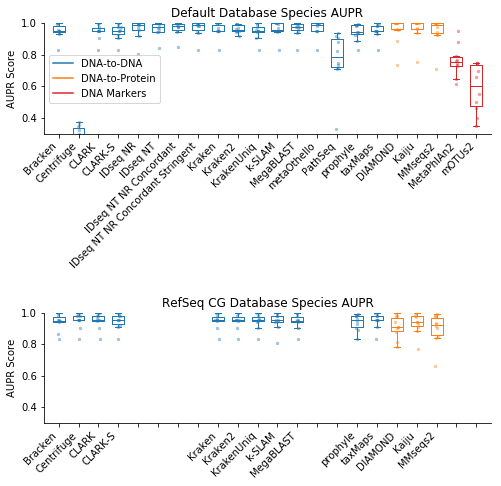

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(6.85, 6.85))

im = aucs[aucs['sample'].isin(truth_samples)]
im_d = im[im['database'].isin(default_dbs)]
im_r = im[im['database'].isin(refseqc_dbs)]

a1 = [(c, im_d.aupr[im_d['classifier'] == c].dropna()) for c in main_classifiers]
a1s = OrderedDict(sorted([(k, v) for k, v in a1], key=grouped_alpha))
a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])
color_boxplot(a1sn, 'Default Database Species AUPR', ylim=[0.3, 1.0], ax=axs[0], ylabel='AUPR Score') 


a2 = [(c, im_r.aupr[im_r['classifier'] == c].dropna()) for c in refseqc_classifiers]
a2s = OrderedDict([(classifiers[k], im_r.aupr[im_r['classifier'] == k].dropna()) for k in a1s.keys()])
color_boxplot(a2s, 'RefSeq CG Database Species AUPR', ylim=[0.3, 1.0], ax=axs[1], ylabel='AUPR Score', legend=False)

axs[1].set_xlim(axs[0].get_xlim())

fig.savefig('pdf/species_aupr.alphabetical.pdf')
fig.savefig('svg/species_aupr.alphabetical.svg')

In [19]:
# fig, axs = plt.subplots(2, 1, figsize=(6.85, 6.85))
# sub_c = ['mmseqs2', 'megablast']

# a1 = [(c, cami_d.aupr[cami_d['classifier'] == c].dropna()) for c in main_classifiers.keys() - sub_c]
# a1s = OrderedDict(sorted([(k, v) for k, v in a1], key=grouped_alpha))
# a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])
# color_boxplot(a1sn, 'CAMI - Default Database Species AUPR', ylim=[0.0, 0.3], ax=axs[0], ylabel='AUPR Score') 

# a2 = [(c, cami_r.aupr[cami_r['classifier'] == c].dropna()) for c in refseqc_classifiers.keys() - sub_c]
# a2s = OrderedDict([(classifiers[k], cami_r.aupr[cami_r['classifier'] == k].dropna()) for k in a1s.keys()])
# color_boxplot(a2s, 'CAMI - RefSeq CG Database Species AUPR', ylim=[0.0, 0.3], ax=axs[1], ylabel='AUPR Score', legend=False)

# axs[1].set_xlim(axs[0].get_xlim())

# fig.savefig('tiff/species_aupr.cami.alphabetical.tiff')
# fig.savefig('svg/species_aupr.cami.alphabetical.svg')

/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '


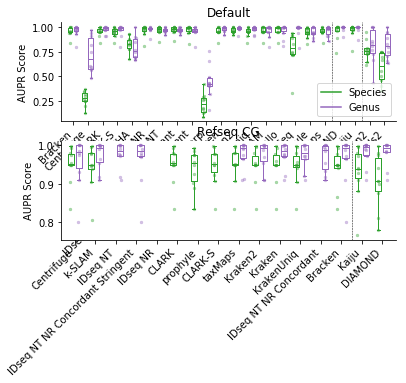

In [20]:
fig, axs = plt.subplots(2, 1)
aupr_colors = np.array(tab20_cycle)[np.array([2, 4])]
sub_c = ['mmseqs2', 'megablast']

a1 = [(c, im_d.aupr[im_d['classifier'] == c].dropna()) for c in classifiers.keys() - sub_c]
a1s, clsf_order, gchanges = order_and_groups(a1, key=grouped_alpha)
a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])

g1 = [(c, img_d.aupr[img_d['classifier'] == c].dropna()) for c in classifiers.keys() - sub_c]
g1s = OrderedDict(sorted([(k, v) for k, v in g1], key=grouped_alpha))
g1sn = OrderedDict([(classifiers[k], v) for k, v in g1s.items()])
n_boxplot([a1sn, g1sn], 'Default', labels=['Species', 'Genus'], ax=axs[0],  ylabel='AUPR Score', legend=True, legend_loc='lower right', colors=aupr_colors, vlines=gchanges)

a1 = [(c, im_r.aupr[im_r['classifier'] == c].dropna()) for c in refseqc_classifiers.keys() - sub_c]
a1s, clsf_order, gchanges = order_and_groups(a1)
a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])

g1 = [(c, img_r.aupr[img_r['classifier'] == c].dropna()) for c in refseqc_classifiers.keys() - sub_c]
g1s = OrderedDict(sorted([(k, v) for k, v in g1], key=grouped_alpha))
g1sn = OrderedDict([(classifiers[k], v) for k, v in g1s.items()])
n_boxplot([a1sn, g1sn], 'Refseq CG', labels=['Species', 'Genus'], ax=axs[1],  ylabel='AUPR Score', legend=None, colors=aupr_colors, vlines=gchanges)

fig.savefig('pdf/species_genus_aupr.alphabetical.pdf')
fig.savefig('svg/species_genus_aupr.alphabetical.svg')

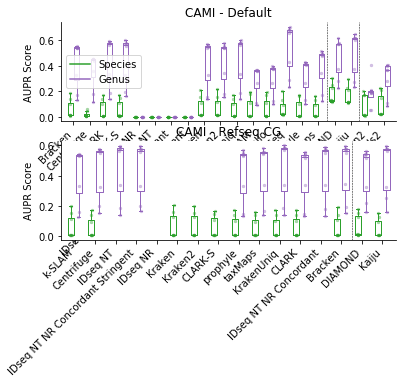

In [21]:
fig, axs = plt.subplots(2, 1)

a1 = [(c, cami_d.aupr[cami_d['classifier'] == c].dropna()) for c in main_classifiers.keys() - sub_c]
a1s, clsf_order, gchanges = order_and_groups(a1, key=grouped_alpha)
a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])

g1 = [(c, camig_d.aupr[camig_d['classifier'] == c].dropna()) for c in main_classifiers.keys() - sub_c]
g1s = OrderedDict(sorted([(k, v) for k, v in g1], key=grouped_alpha))
g1sn = OrderedDict([(classifiers[k], v) for k, v in g1s.items()])
n_boxplot([a1sn, g1sn], 'CAMI - Default', labels=['Species', 'Genus'], ax=axs[0],  ylabel='AUPR Score', legend='best', colors=aupr_colors, vlines=gchanges)

a1 = [(c, cami_r.aupr[cami_r['classifier'] == c].dropna()) for c in refseqc_classifiers.keys() - sub_c]
a1s, clsf_order, gchanges = order_and_groups(a1)
a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])

g1 = [(c, camig_r.aupr[camig_r['classifier'] == c].dropna()) for c in refseqc_classifiers.keys() - sub_c]
g1s = OrderedDict(sorted([(k, v) for k, v in g1], key=grouped_alpha))
g1sn = OrderedDict([(classifiers[k], v) for k, v in g1s.items()])
n_boxplot([a1sn, g1sn], 'CAMI - Refseq CG', labels=['Species', 'Genus'], ax=axs[1],  ylabel='AUPR Score', legend=None, colors=aupr_colors, vlines=gchanges)

fig.savefig('pdf/species_genus_aupr.cami.alphabetical.pdf')
fig.savefig('svg/species_genus_aupr.cami.alphabetical.svg')

In [22]:
# fig, axs = plt.subplots(2, 1, figsize=(6.85, 6.85))

# a1 = [(c, camig_d.aupr[camig_d['classifier'] == c].dropna()) for c in main_classifiers.keys() - sub_c]
# a1s = OrderedDict(sorted([(k, v) for k, v in a1], key=grouped_alpha))
# a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])
# color_boxplot(a1sn, 'CAMI - Default Database Genus AUPR', ylim=[0.0, 1.0], ax=axs[0], ylabel='AUPR Score') 

# a2 = [(c, camig_r.aupr[camig_r['classifier'] == c].dropna()) for c in refseqc_classifiers.keys() - sub_c]
# a2s = OrderedDict([(classifiers[k], camig_r.aupr[camig_r['classifier'] == k].dropna()) for k in a1s.keys()])
# color_boxplot(a2s, 'CAMI - RefSeq CG Database Genus AUPR', ylim=[0.0, 1.0], ax=axs[1], ylabel='AUPR Score', legend=False)

# axs[1].set_xlim(axs[0].get_xlim())

# fig.savefig('png/genus_aupr.cami.alphabetical.png')
# fig.savefig('svg/genus_aupr.cami.alphabetical.svg')

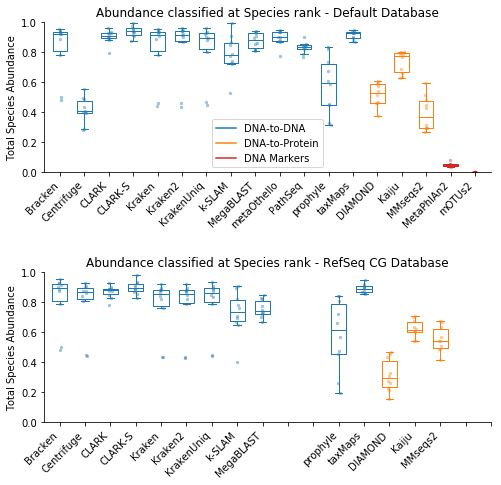

In [23]:
ranks = ['species', 'genus']
a = []
for rank in ranks:
    fdf = rank_abundances_df[(rank_abundances_df['rank'] == rank) & (rank_abundances_df['database'].isin(default_dbs)) &
                             (rank_abundances_df['sample'].isin(truth_samples))]
    a.append(collections.defaultdict(list, {k: v['abundance'] for k, v in fdf.groupby('classifier') if k in main_classifiers}))
    
r = []
for rank in ranks:
    fdf = rank_abundances_df[(rank_abundances_df['rank'] == rank) & (rank_abundances_df['database'].isin(refseqc_dbs)) &
                             (rank_abundances_df['sample'].isin(truth_samples))]
    r.append(collections.defaultdict(list, {k: v['abundance'] for k, v in fdf.groupby('classifier') if k in refseqc_classifiers})) 


fig, axs = plt.subplots(2, 1, figsize=(6.85, 6.85))

a[0], clsf_order, gchanges = order_and_groups(a[0].items(), key=grouped_alpha)
a[0] = OrderedDict((classifiers[c], a[1][c]) for c in clsf_order)
color_boxplot(a[0], 'Abundance classified at Species rank - Default Database', labels=['Species'], 
          ylim=[0, 1], ax=axs[0], ylabel='Total Species Abundance')

r0 = OrderedDict((classifiers[k], r[0][k]) for k in clsf_order)
color_boxplot(r0, title='Abundance classified at Species rank - RefSeq CG Database', labels=['Species'], legend=None, 
          ylim=[0, 1], ax=axs[1], ylabel='Total Species Abundance')

fig.savefig('pdf/classified_proportion.pdf')
fig.savefig('svg/classified_proportion.svg')

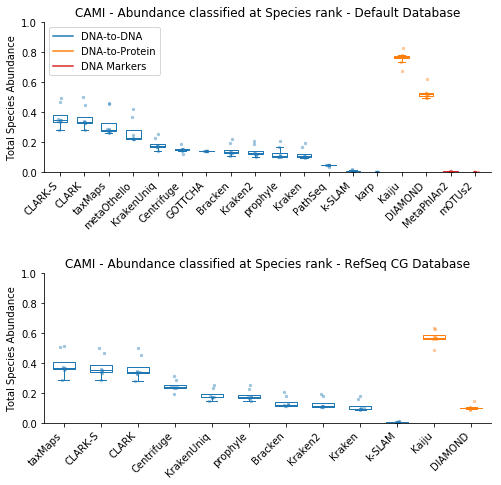

In [24]:
ranks = ['species', 'genus']
a = []
r = []
ridx = (rank_abundances_df['rank'] == rank) & (rank_abundances_df['sample'].isin(cami_samples))
for rank in ranks:
    fdf = rank_abundances_df[ridx & (rank_abundances_df['database'].isin(default_dbs))]
    a.append({classifiers[k]: v['abundance'] for k, v in fdf.groupby('classifier') if k in classifiers})
    fdf = rank_abundances_df[ridx & (rank_abundances_df['database'].isin(refseqc_dbs))]
    r.append({classifiers[k]: v['abundance'] for k, v in fdf.groupby('classifier') if k in refseqc_classifiers})  

fig, axs = plt.subplots(2, 1, figsize=(6.85, 6.85))

a[0], clsf_order, gchanges = order_and_groups(a[0].items())
a[1] = OrderedDict((clsf, a[1][clsf]) for clsf in clsf_order)
color_boxplot(a[0], 'CAMI - Abundance classified at Species rank - Default Database', labels=['Species'], 
          ylim=[0, 1], ax=axs[0], ylabel='Total Species Abundance')

r[0], clsf_order, gchanges = order_and_groups(r[0].items())
color_boxplot(r[0], title='CAMI - Abundance classified at Species rank - RefSeq CG Database', labels=['Species'], legend=None, 
          ylim=[0, 1], ax=axs[1], ylabel='Total Species Abundance')

fig.savefig('pdf/classified_proportion.cami.pdf')
fig.savefig('svg/classified_proportion.cami.svg')

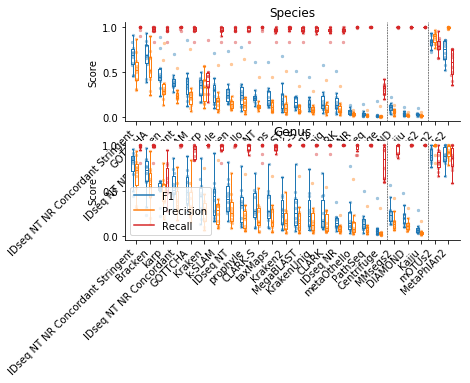

In [25]:
fig, axs = plt.subplots(2, 1)

f = [(c, im_d.f[im_d['classifier'] == c].dropna()) for c in classifiers]
f, clsf_order, gchanges = order_and_groups(f)
p = OrderedDict((c, im_d.p[im_d['classifier'] == c].dropna()) for c in clsf_order)
r = OrderedDict((c, im_d.r[im_d['classifier'] == c].dropna()) for c in clsf_order)
f = OrderedDict([(classifiers[c], x) for c, x in f.items()])
n_boxplot([f, p, r], 'Species', labels=['F1', 'Precision', 'Recall'], ax=axs[0], vlines=gchanges, ylabel='Score', legend=None)
         # legend_loc='lower left')#, bbox_to_anchor=(1.0, 0.5)) 

f = [(c, img_d.f[img_d['classifier'] == c].dropna()) for c in classifiers]
f, clsf_order, gchanges = order_and_groups(f)
p = OrderedDict((c, img_d.p[img_d['classifier'] == c].dropna()) for c in clsf_order)
r = OrderedDict((c, img_d.r[img_d['classifier'] == c].dropna()) for c in clsf_order)
f = OrderedDict([(classifiers[c], x) for c, x in f.items()])

n_boxplot([f, p, r], 'Genus', labels=['F1', 'Precision', 'Recall'], ax=axs[1], vlines=gchanges,
          legend_loc='lower left', ylabel='Score')


fig.savefig('pdf/f1_precision_recall.pdf')
fig.savefig('svg/f1_precision_recall.svg')

In [26]:
def p_truth_distances(rank='species', classifiers=main_classifiers, classranks=['species', 'all'], 
                      databases=default_dbs, metric='euclidean', samples=truth_samples):
    dists = collections.defaultdict(list)

    for sample in samples:
        idx = ((df['rank'] == rank) & (df['sample'] == sample) & (df['classifier'].isin(classifiers)) & 
               (df['classrank'].isin(classranks)) & (df['database'].isin(databases))
              )
        colname = '{}_abundance'.format(rank)
        ds = df.loc[idx, ('classifier', 'taxid', colname)]
        tdf = sample_truth_df(truth_df, sample, rank=rank)
        pacc = pd.concat([ds.pivot_table(index='taxid', columns='classifier', values=colname).fillna(0).T,
            tdf.pivot_table(index='taxid', values='abundance').T.rename({'abundance': 'truth'})],
                            sort=False).fillna(0)

        Y = squareform(pdist(pacc, metric=metric))

        for i, classifier in enumerate(list(pacc.index[:-1])):
            dists[classifier].append(Y[-1, i])
    return dists

def asc_grouped_score(item):
    clsf, values = item
    return classifier_group_order[clsf], np.median(values), np.mean(values)

In [27]:
def pp_truth_distances(rank='species', classifiers=main_classifiers, classranks=['species', 'all'], 
                      databases=default_dbs, metric='euclidean', samples=truth_samples):
    dists = collections.defaultdict(list)

    for sample in samples:
        idx = ((df['rank'] == rank) & (df['sample'] == sample) & (df['classifier'].isin(classifiers)) & 
               (df['classrank'].isin(classranks)) & (df['database'].isin(databases))
              )
        colname = '{}_abundance'.format(rank)
        ds = df.loc[idx, ('classifier', 'taxid', colname)]
        tdf = sample_truth_df(truth_df, sample, rank=rank)
        pacc = pd.concat([ds.pivot_table(index='taxid', columns='classifier', values=colname).fillna(0).T,
            tdf.pivot_table(index='taxid', values='abundance').T.rename({'abundance': 'truth'})],
                            sort=False).fillna(0)
        Y = squareform(pdist(pacc, metric=metric))

        for i, classifier in enumerate(list(pacc.index[:-1])):
            dists[classifier].append(Y[-1, i])
    return dists



g1s = pp_truth_distances(rank='genus', classranks=['genus', 'all'], classifiers=['kraken'], databases=refseqc_dbs)


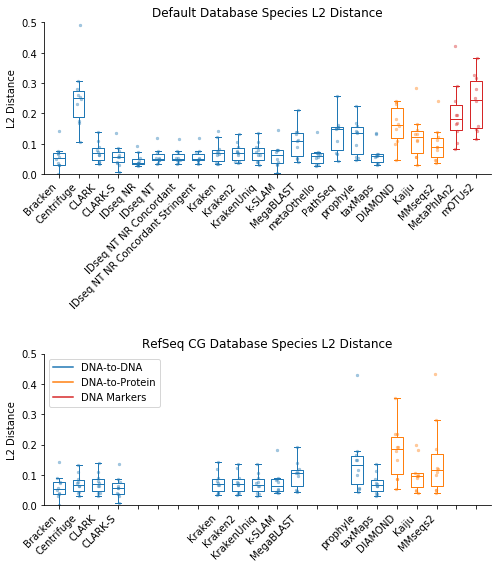

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(6.85, 8))

a1 = p_truth_distances()
a1s = OrderedDict(sorted([(k, v) for k, v in a1.items()], key=grouped_alpha))
a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])
color_boxplot(a1sn, 'Default Database Species L2 Distance', ylim=[0, 0.5], ax=axs[0], ylabel='L2 Distance', legend=None)

# KK EDIT
out_df = pd.DataFrame(a1)
out_df.index = im_d.pivot(index='sample', columns='classifier')['aupr'].index
out_df.to_csv('../../data/output_l2.csv')

a2 = p_truth_distances(classifiers=refseqc_classifiers, databases=refseqc_dbs)
a2s = OrderedDict([(classifiers[k], a2[k]) for k in a1s.keys()])
color_boxplot(a2s, 'RefSeq CG Database Species L2 Distance', ylim=[0, 0.5], ax=axs[1], ylabel='L2 Distance', legend=True, legend_loc='upper left')
axs[1].set_xlim(axs[0].get_xlim())


fig.savefig('pdf/species_l2.alphabetical.pdf')
fig.savefig('svg/species_l2.alphabetical.svg')

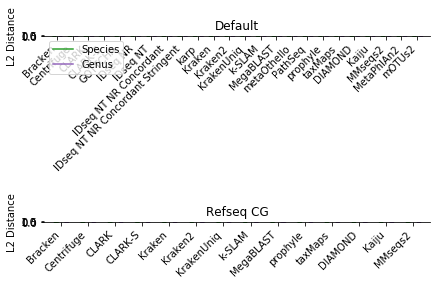

In [29]:
fig, axs = plt.subplots(2, 1)

a1 = p_truth_distances(classifiers=classifiers)
a1s, clsf_order, gchanges = order_and_groups(a1.items(), key=grouped_alpha)
a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])

g1s = p_truth_distances(classifiers=classifiers, rank='genus', classranks=['genus', 'all'])
g1sn = OrderedDict([(classifiers[k], g1s[k]) for k in a1s])
n_boxplot([a1sn, g1sn], 'Default', labels=['Species', 'Genus'], ax=axs[0], ylim=[0, 0.55], ylabel='L2 Distance', legend='best', legend_loc='upper left', colors=aupr_colors, vlines=gchanges)

a1 = p_truth_distances(classifiers=refseqc_classifiers, databases=refseqc_dbs)
a1s, clsf_order, gchanges = order_and_groups(a1.items(), key=grouped_alpha)
a1sn = OrderedDict([(classifiers[k], v) for k, v in a1s.items()])

g1s = p_truth_distances(rank='genus', classranks=['genus', 'all'], classifiers=refseqc_classifiers, databases=refseqc_dbs)
g1sn = OrderedDict([(classifiers[k], g1s[k]) for k in a1s])
n_boxplot([a1sn, g1sn], 'Refseq CG', labels=['Species', 'Genus'], ax=axs[1], ylim=[0, 0.55], ylabel='L2 Distance', legend=None, colors=aupr_colors, vlines=gchanges)

fig.savefig('pdf/species_genus_l2.alphabetical.pdf')
fig.savefig('svg/species_genus_l2.alphabetical.svg')

**END IDseq analysis** - commented out remaining sections; these analyses are not included in idseq-benchmark-manuscript.

-----------

In [30]:
'''clabels = ['DNA-to-DNA', 'DNA-to-Protein', 'DNA Markers']
def plot_taxa_inflation_grouped(df, sample, classifiers=main_classifiers, xlim=None, ylim=None, xmax=None, 
                       loglog=True, ax=None, xlabel=None, ylabel=None, title=None, legend=None,
                       draw_truth=True):
    if not ax:
        _, ax = plt.subplots()
    xmax = xmax or 1e-6
    lines = []
    labels = []
    for classifier in classifiers:
        fdf = filter_df(df, classifier=classifier, sample=sample)
        fdf = fdf[~fdf['species_abundance'].isnull()]

        abunds = fdf[['taxid', 'species_abundance']].sort_values(
            'species_abundance', ascending=False)['species_abundance'].reset_index(drop=True)
        if abunds.min() > xmax:
            abunds = abunds.append(pd.Series([xmax], index=[abunds.index[-1]]))
        if loglog:
            lines.append(ax.loglog(abunds, abunds.index, color=cb_colors[classifier_group_order[classifier]], label=classifier_group_order[classifier])[0])
        else:
            lines.append(ax.semilogx(abunds, abunds.index, color=cb_colors[classifier_group_order[classifier]], label=classifier_group_order[classifier])[0])
        labels.append(clabels[classifier_group_order[classifier]])

    if draw_truth:
        lines.insert(0, ax.plot([0.05, 0.05, 1e-6], [0, 20, 20], 'k--', lw=1)[0])
        labels.insert(0, 'Truth')
    ax.invert_xaxis()

    # Reduce # of ticks
    subs = [2, 4, 6, 8]
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))

    if xlim:
        ax.set_xlim(xlim)
    else:
        ax.set_xlim(xmin=1, xmax=xmax)        
    if ylim:
        ax.set(ylim=ylim)
    if ylabel:
        ax.set(ylabel=ylabel)
    if title:
        ax.set(title=title)
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return lines, labels

fig, axes = plt.subplots(2, 2, figsize=(6.85, 6), sharex=True, sharey=True, tight_layout=True, constrained_layout=False)
    
custom_lines = [matplotlib.lines.Line2D([0], [0], color=cb_colors[i], lw=4) for i in range(3)]
axes[0, 0].legend(custom_lines, clabels, loc='upper left')

plot_taxa_inflation_grouped(df, 'atcc_even', ax=axes[0][0], 
                    title='Simulated DNA ({} reads)'.format(read_stats.loc['atcc_even.art', 'reads']))
plot_taxa_inflation_grouped(df, 'DNA1', ax=axes[0][1], 
                    title='Real DNA ({} reads)'.format(read_stats.loc['DNA1', 'reads']))
plot_taxa_inflation_grouped(df, 'RNA1', ax=axes[1][0], 
                    title='Real RNA ({} reads)'.format(read_stats.loc['RNA1', 'reads']))

lines, labels = plot_taxa_inflation_grouped(
    df, 'NTC', ax=axes[1][1], draw_truth=False,
    title='Negative Control ({} reads)'.format(read_stats.loc['NTC', 'reads']))

fig.text(0.5, -0.02, "Abundance Fraction", ha="center", va="center")
fig.text(-0.02, 0.5, "Number of Species", ha="center", va="center", rotation=90)

fig.savefig('svg/taxa_inflation.grouped.svg', bbox_inches='tight')
fig.savefig('pdf/taxa_inflation.grouped.pdf', bbox_inches='tight')'''

'clabels = [\'DNA-to-DNA\', \'DNA-to-Protein\', \'DNA Markers\']\ndef plot_taxa_inflation_grouped(df, sample, classifiers=main_classifiers, xlim=None, ylim=None, xmax=None, \n                       loglog=True, ax=None, xlabel=None, ylabel=None, title=None, legend=None,\n                       draw_truth=True):\n    if not ax:\n        _, ax = plt.subplots()\n    xmax = xmax or 1e-6\n    lines = []\n    labels = []\n    for classifier in classifiers:\n        fdf = filter_df(df, classifier=classifier, sample=sample)\n        fdf = fdf[~fdf[\'species_abundance\'].isnull()]\n\n        abunds = fdf[[\'taxid\', \'species_abundance\']].sort_values(\n            \'species_abundance\', ascending=False)[\'species_abundance\'].reset_index(drop=True)\n        if abunds.min() > xmax:\n            abunds = abunds.append(pd.Series([xmax], index=[abunds.index[-1]]))\n        if loglog:\n            lines.append(ax.loglog(abunds, abunds.index, color=cb_colors[classifier_group_order[classifier]], labe

In [31]:
'''def plot_taxa_inflation(df, sample, classifiers=main_classifiers, xlim=None, ylim=None, xmax=None, 
                       loglog=True, ax=None, xlabel=None, ylabel=None, title=None, legend=None,
                       draw_truth=True):
    if not ax:
        _, ax = plt.subplots()
    xmax = xmax or 1e-6
    ax.set_prop_cycle(color=tab20_cycle)
    lines = []
    labels = []
    for classifier in classifiers:
        fdf = filter_df(df, classifier=classifier, sample=sample)
        fdf = fdf[~fdf['species_abundance'].isnull()]

        abunds = fdf[['taxid', 'species_abundance']].sort_values(
            'species_abundance', ascending=False)['species_abundance'].reset_index(drop=True)
        if abunds.min() > xmax:
            abunds = abunds.append(pd.Series([xmax], index=[abunds.index[-1]]))
        if loglog:
            lines.append(ax.loglog(abunds, abunds.index, label=classifier)[0])
        else:
            lines.append(ax.semilogx(abunds, abunds.index, label=classifier)[0])
        labels.append(classifiers[classifier])

    if draw_truth:
        lines.insert(0, ax.plot([0.05, 0.05, 1e-6], [0, 20, 20], 'k--', lw=1)[0])
        labels.insert(0, 'Truth')
    ax.invert_xaxis()

    # Reduce # of ticks
    subs = [2, 4, 6, 8]
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))
    
    if xlim:
        ax.set_xlim(xlim)
    else:
        ax.set_xlim(xmin=1, xmax=xmax)        
    if ylim:
        ax.set(ylim=ylim)
    if ylabel:
        ax.set(ylabel=ylabel)
    if title:
        ax.set(title=title)
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return lines, labels'''

"def plot_taxa_inflation(df, sample, classifiers=main_classifiers, xlim=None, ylim=None, xmax=None, \n                       loglog=True, ax=None, xlabel=None, ylabel=None, title=None, legend=None,\n                       draw_truth=True):\n    if not ax:\n        _, ax = plt.subplots()\n    xmax = xmax or 1e-6\n    ax.set_prop_cycle(color=tab20_cycle)\n    lines = []\n    labels = []\n    for classifier in classifiers:\n        fdf = filter_df(df, classifier=classifier, sample=sample)\n        fdf = fdf[~fdf['species_abundance'].isnull()]\n\n        abunds = fdf[['taxid', 'species_abundance']].sort_values(\n            'species_abundance', ascending=False)['species_abundance'].reset_index(drop=True)\n        if abunds.min() > xmax:\n            abunds = abunds.append(pd.Series([xmax], index=[abunds.index[-1]]))\n        if loglog:\n            lines.append(ax.loglog(abunds, abunds.index, label=classifier)[0])\n        else:\n            lines.append(ax.semilogx(abunds, abunds.index, l

In [32]:
'''# Plot taxa inflation vs abundance for a few selected datasets

fig, axes = plt.subplots(2, 2, figsize=(6.85, 6), sharex=True, sharey=True, tight_layout=True, constrained_layout=False)
    
plot_taxa_inflation(df, 'atcc_even', ax=axes[0][0], classifiers=classifiers,
                    title='Simulated DNA ({} reads)'.format(read_stats.loc['atcc_even.art', 'reads']))
plot_taxa_inflation(df, 'DNA1', ax=axes[0][1], classifiers=classifiers,
                    title='Real DNA ({} reads)'.format(read_stats.loc['DNA1', 'reads']))
plot_taxa_inflation(df, 'RNA1', ax=axes[1][0], classifiers=classifiers,
                    title='Real RNA ({} reads)'.format(read_stats.loc['RNA1', 'reads']))

lines, labels = plot_taxa_inflation(
    df, 'NTC', ax=axes[1][1], draw_truth=False, classifiers=classifiers,
    title='Negative Control ({} reads)'.format(read_stats.loc['NTC', 'reads']))
leg = fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.text(0.5, -0.02, "Abundance Fraction", ha="center", va="center")
fig.text(-0.02, 0.5, "Number of Species", ha="center", va="center", rotation=90)

fig.savefig('svg/taxa_inflation.svg', bbox_extra_artists=[leg], bbox_inches='tight')
fig.savefig('pdf/taxa_inflation.pdf', bbox_inches='tight')'''

'# Plot taxa inflation vs abundance for a few selected datasets\n\nfig, axes = plt.subplots(2, 2, figsize=(6.85, 6), sharex=True, sharey=True, tight_layout=True, constrained_layout=False)\n    \nplot_taxa_inflation(df, \'atcc_even\', ax=axes[0][0], classifiers=classifiers,\n                    title=\'Simulated DNA ({} reads)\'.format(read_stats.loc[\'atcc_even.art\', \'reads\']))\nplot_taxa_inflation(df, \'DNA1\', ax=axes[0][1], classifiers=classifiers,\n                    title=\'Real DNA ({} reads)\'.format(read_stats.loc[\'DNA1\', \'reads\']))\nplot_taxa_inflation(df, \'RNA1\', ax=axes[1][0], classifiers=classifiers,\n                    title=\'Real RNA ({} reads)\'.format(read_stats.loc[\'RNA1\', \'reads\']))\n\nlines, labels = plot_taxa_inflation(\n    df, \'NTC\', ax=axes[1][1], draw_truth=False, classifiers=classifiers,\n    title=\'Negative Control ({} reads)\'.format(read_stats.loc[\'NTC\', \'reads\']))\nleg = fig.legend(lines, labels, loc=\'center left\', bbox_to_anchor=(1

In [33]:
'''tax_db = ncbitax.TaxonomyDb(tax_dir=os.path.expanduser('~/metax/taxonomy/20180425'), load_names=True, load_nodes=True, load_merged=True)

hg_taxid = 9606
human_path_taxids = []
taxid = hg_taxid
while taxid != 33208:
    human_path_taxids.append(taxid)
    taxid = tax_db.parents[taxid]
    
human_path_taxids.append(33208)
bacteria_taxids = list(ncbitax.collect_children(tax_db.children, {2}))
viruses_taxids = list(ncbitax.collect_children(tax_db.children, {10239}))'''

"tax_db = ncbitax.TaxonomyDb(tax_dir=os.path.expanduser('~/metax/taxonomy/20180425'), load_names=True, load_nodes=True, load_merged=True)\n\nhg_taxid = 9606\nhuman_path_taxids = []\ntaxid = hg_taxid\nwhile taxid != 33208:\n    human_path_taxids.append(taxid)\n    taxid = tax_db.parents[taxid]\n    \nhuman_path_taxids.append(33208)\nbacteria_taxids = list(ncbitax.collect_children(tax_db.children, {2}))\nviruses_taxids = list(ncbitax.collect_children(tax_db.children, {10239}))"

In [34]:
'''fig, axs = plt.subplots(2, 1,  figsize=(6.85, 6.85))

colors = np.array(tab20_cycle)[np.array([9, 6, 7])]
def tax_categories(sample, ax, title, legend=True):
    fdf = df[(df['sample'] == sample) & (df['database'].isin(default_dbs)) & (df['classrank'].isin(['species', 'all']))]
    fdf = fdf[fdf['classifier'].isin(classifiers)].groupby(['classifier', 'taxid']).sum().reset_index()
    fdf = fdf.loc[fdf['taxid'].isin([33208, 2, 10239, 0, 12908]), ['classifier', 'taxid', 'cum_abundance']].pivot_table('cum_abundance', 'classifier', 'taxid').fillna(0)
    fdf['Unclassified'] = fdf[0] + fdf[12908]
    fdf = fdf.rename(columns={2: 'Bacteria', 33208: 'Metazoans', 10239: 'Viruses'})
    fdf['Other Non-Metazoans'] = 1 - fdf['Unclassified'] - fdf['Metazoans'] - fdf['Viruses'] - fdf['Bacteria']
    fdf['miss_sum'] = fdf['Bacteria'] + fdf['Viruses'] + fdf['Other Non-Metazoans']
    fdf = fdf.sort_values('miss_sum')

    width = 0.8
    dim = 1
    lim = (dim - 1) * (width / 2)
    offsets = np.linspace(-lim, lim, dim)

    taxs = ['Bacteria', 'Viruses', 'Other Non-Metazoans']
    miss = fdf.loc[:, taxs].sum(axis=1)
    miss = miss[miss > 1e-6]
    n = len(miss)
    n_range = np.arange(n)
    ax.bar(n_range, list(miss), log=True, color=colors[0])

    # Reduce # of ticks
    subs = [2, 4, 6, 8]
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))
    
    ax.set(ylabel='Abundance', title=title, ylim=1e-6)
    ax.set_xticks(n_range * dim)
    ax.set_xticklabels([classifiers[k] for k in miss.index], rotation=45, ha='right')


tax_categories('hg38', axs[0], 'Hg38 Misclassifications')
tax_categories('NTC', axs[1], 'NTC Hits', legend=False)

fig.savefig('pdf/misclassifications.pdf')
fig.savefig('svg/misclassifications.svg')'''

"fig, axs = plt.subplots(2, 1,  figsize=(6.85, 6.85))\n\ncolors = np.array(tab20_cycle)[np.array([9, 6, 7])]\ndef tax_categories(sample, ax, title, legend=True):\n    fdf = df[(df['sample'] == sample) & (df['database'].isin(default_dbs)) & (df['classrank'].isin(['species', 'all']))]\n    fdf = fdf[fdf['classifier'].isin(classifiers)].groupby(['classifier', 'taxid']).sum().reset_index()\n    fdf = fdf.loc[fdf['taxid'].isin([33208, 2, 10239, 0, 12908]), ['classifier', 'taxid', 'cum_abundance']].pivot_table('cum_abundance', 'classifier', 'taxid').fillna(0)\n    fdf['Unclassified'] = fdf[0] + fdf[12908]\n    fdf = fdf.rename(columns={2: 'Bacteria', 33208: 'Metazoans', 10239: 'Viruses'})\n    fdf['Other Non-Metazoans'] = 1 - fdf['Unclassified'] - fdf['Metazoans'] - fdf['Viruses'] - fdf['Bacteria']\n    fdf['miss_sum'] = fdf['Bacteria'] + fdf['Viruses'] + fdf['Other Non-Metazoans']\n    fdf = fdf.sort_values('miss_sum')\n\n    width = 0.8\n    dim = 1\n    lim = (dim - 1) * (width / 2)\n    

In [35]:
'''l2_classifiers = set(main_classifiers) - {'centrifuge'}
l2s = []

for sample in truth_samples:
    idx = ((df['rank'] == 'species') & (df['sample'] == sample) & (df['classifier'].isin(l2_classifiers)) & 
           (df['classrank'].isin(['species', 'all'])) & (df['database'].isin(default_dbs)))
    ds = df.loc[idx, ('classifier', 'taxid', 'species_abundance')]
    # Use centrifuge RefSeq CG instead of default
    idx = ((df['rank'] == 'species') & (df['sample'] == sample) & (df['classifier'] == 'centrifuge') & 
           (df['classrank'].isin(['species', 'all'])) & (df['database'] == 'refseqc'))
    centrifuge_ds = df.loc[idx, ('classifier', 'taxid', 'species_abundance')]

    ds = pd.concat([ds, centrifuge_ds])
    
    pds = ds.pivot_table(index='taxid', columns='classifier', values='species_abundance').fillna(0).T
    l2_index = pds.index
    Y = squareform(pdist(pds, 'euclidean'))
    l2s.append(Y)
    
l2s = np.stack(l2s)

l2m = np.median(l2s, axis=0)
l2m_condensed = squareform(l2m)
'''

"l2_classifiers = set(main_classifiers) - {'centrifuge'}\nl2s = []\n\nfor sample in truth_samples:\n    idx = ((df['rank'] == 'species') & (df['sample'] == sample) & (df['classifier'].isin(l2_classifiers)) & \n           (df['classrank'].isin(['species', 'all'])) & (df['database'].isin(default_dbs)))\n    ds = df.loc[idx, ('classifier', 'taxid', 'species_abundance')]\n    # Use centrifuge RefSeq CG instead of default\n    idx = ((df['rank'] == 'species') & (df['sample'] == sample) & (df['classifier'] == 'centrifuge') & \n           (df['classrank'].isin(['species', 'all'])) & (df['database'] == 'refseqc'))\n    centrifuge_ds = df.loc[idx, ('classifier', 'taxid', 'species_abundance')]\n\n    ds = pd.concat([ds, centrifuge_ds])\n    \n    pds = ds.pivot_table(index='taxid', columns='classifier', values='species_abundance').fillna(0).T\n    l2_index = pds.index\n    Y = squareform(pdist(pds, 'euclidean'))\n    l2s.append(Y)\n    \nl2s = np.stack(l2s)\n\nl2m = np.median(l2s, axis=0)\nl2m_c

In [36]:
'''fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(6.85, 9), gridspec_kw = {'height_ratios':[1.5, 1, 4.5]})

kmer_classifiers = ['kraken', 'krakenhll', 'clark', 'clark_s', 'bracken', 'kslam', 'metaothello', 'kraken2']
N = len(l2_index)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scipy.cluster.hierarchy.set_link_color_palette(colors[5:])

cmap = matplotlib.cm.get_cmap('viridis', 10) # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'

Z = scipy.cluster.hierarchy.linkage(l2m_condensed)

dn = scipy.cluster.hierarchy.dendrogram(Z, ax=ax0, color_threshold=0.09, above_threshold_color='k') #, link_color_func=lambda x: 'k') #, color_threshold=0.4, above_threshold_color='C0')

idx = dn['leaves']
l2m_clustered = l2m[idx,:]
l2m_clustered = l2m_clustered[:,idx]

ax0.set_xticks([])
ax0.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(True)

cb_map = matplotlib.colors.LinearSegmentedColormap.from_list('colorblind_tab', cb_colors)
group_colors = [[classifier_group_order[x] for x in l2_index[idx]]]
im = ax1.imshow(group_colors, alpha=0.5, cmap=cb_map, aspect='equal')
for i, x in enumerate(l2_index[idx]):
    if x in kmer_classifiers:
        ax1.text(i, 0, 'k', ha='center', va='center', color='k', fontsize=8)
ax1.yaxis.set_visible(False)
ax1.set_xticklabels([])

ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.set_xticks(np.arange(-.5, N, 1), minor=True);
ax1.grid(which='minor', color='k', linestyle='-', linewidth=1)
for (j,i), label in np.ndenumerate(l2m_clustered):
    if j > i:
        ax2.text(i, j,'{:.2f}'.format(label), ha='center', va='center', fontsize=8)

im = ax2.imshow(l2m_clustered, alpha=0.5, cmap=cmap, aspect='equal')
fig.colorbar(im, ax=ax2, shrink=0.7)

ax2.set_xticks(np.arange(N))
ax2.set_yticks(np.arange(N))
ax2.set_xticklabels([classifiers[c] for c in l2_index[idx]], rotation='45', ha='right')
ax2.set_yticklabels([classifiers[c] for c in l2_index[idx]])
fig.set_constrained_layout_pads(hspace=-0.10, h_pad=0, wspace=0, w_pad=0)

fig.savefig('pdf/l2_matrix.pdf', bbox_inches='tight')
fig.savefig('svg/l2_matrix.svg', bbox_inches='tight')
'''

"fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(6.85, 9), gridspec_kw = {'height_ratios':[1.5, 1, 4.5]})\n\nkmer_classifiers = ['kraken', 'krakenhll', 'clark', 'clark_s', 'bracken', 'kslam', 'metaothello', 'kraken2']\nN = len(l2_index)\ncolors = plt.rcParams['axes.prop_cycle'].by_key()['color']\nscipy.cluster.hierarchy.set_link_color_palette(colors[5:])\n\ncmap = matplotlib.cm.get_cmap('viridis', 10) # jet doesn't have white color\ncmap.set_bad('w') # default value is 'k'\n\nZ = scipy.cluster.hierarchy.linkage(l2m_condensed)\n\ndn = scipy.cluster.hierarchy.dendrogram(Z, ax=ax0, color_threshold=0.09, above_threshold_color='k') #, link_color_func=lambda x: 'k') #, color_threshold=0.4, above_threshold_color='C0')\n\nidx = dn['leaves']\nl2m_clustered = l2m[idx,:]\nl2m_clustered = l2m_clustered[:,idx]\n\nax0.set_xticks([])\nax0.spines['bottom'].set_visible(False)\nax1.spines['top'].set_visible(True)\nax1.spines['right'].set_visible(True)\nax2.spines['top'].set_visible(True)\nax2.spines[

In [37]:
'''classifier_names = {'.kaiju.': 'kaiju',
                   '.metaothello.': 'metaothello',
                   '.taxmaps.lca.': 'taxmaps',
                   '.kraken.': 'kraken',
                   '.clark.': 'clark',
                    '.clark_s.': 'clark_s',
                    '.clark_genus.': 'clark',
                    '.clark_s_genus.': 'clark_s',
                   '.krakenhll.': 'krakenhll',
                   '.centrifuge.': 'centrifuge'}

rdfs = []
for fn in os.listdir('readclass'):
    for cls_inside, cls in classifier_names.items():
        if cls_inside in fn:
            ind = fn.find(cls_inside)
            sample = fn[:fn.find(cls_inside)]
            db = fn[ind+len(cls_inside):].split('.')[0]
            classrank = 'all'
            
            if cls_inside.endswith('_genus.'):
                classrank = 'genus'
            if sample.endswith('.art'):
                sample = sample[:-4]
            
            rdf = pd.read_csv(os.path.join('readclass', fn), sep='\t', low_memory=False)
            rdf['sample'] = sample
            rdf['classifier'] = cls
            rdf['database'] = db
            rdf['classrank'] = classrank
            rdfs.append(rdf)
            break

rdf = pd.concat(rdfs)

def parent_rank_map(taxids=None, rank='species'):
    if taxids is None:
        taxids = tax_db.names.keys()
    parent_rank_map = {}
    for taxid in taxids:
        path = tax_db.parent_path(taxid, warn_missing=False)
        if not path:
            continue
        path.insert(0, taxid)
        for p in path:
            if tax_db.ranks[p] == rank:
                parent_rank_map[taxid] = p

    return parent_rank_map

parent_species_map = parent_rank_map(set(rdf['taxid']) | set(rdf['truth_taxid']))
parent_species_df = pd.DataFrame.from_dict(parent_species_map, orient='index', columns=['species_taxid'])
parent_species_df.index.name = 'taxid'

rdf2 = rdf.copy()
rdf2 = rdf2.merge(parent_species_df, left_on='truth_taxid', right_index=True, how='left')
rdf2 = rdf2.rename(index=str, columns={'species_taxid': 'species_truth_taxid'})
rdf2 = rdf2.merge(parent_species_df, left_on='taxid', right_index=True, how='left')
rdf = rdf2

pdist_rows = []

for k, gr in rdf.groupby(['sample', 'classifier', 'database', 'classrank']):
    sample, classifier, database, classrank = k
    if classrank == 'genus':
        continue
    if database not in refseqc_dbs:
        continue
    if sample not in truth_samples:
        continue
    idx = ((df['classifier'] == classifier) & (df['rank'] == 'species') & (df['sample'] == sample) & 
           (df['database'] == database) & (df['classrank'].isin(['species', 'all']))
          )
    reads_abundance = gr.groupby('species_taxid').sum()['count'] / gr.loc[~gr['species_taxid'].isnull(), 'count'].sum()
    
    report_abundance = df.loc[idx, ['taxid', 'species_abundance']].copy()
    report_abundance['taxid'] = report_abundance['taxid'].astype(int)
    report_abundance = report_abundance.groupby('taxid').sum()['species_abundance']

    abunds = pd.concat([reads_abundance, report_abundance], axis=1).fillna(0).T
    dist = pdist(abunds, 'euclidean')[0]
    pdist_rows.append({
        'sample': sample,
        'classifier': classifier,
        'database': database,
        'classrank': classrank,
        'l2': dist,
    })
pdist_df = pd.DataFrame(pdist_rows)
'''

"classifier_names = {'.kaiju.': 'kaiju',\n                   '.metaothello.': 'metaothello',\n                   '.taxmaps.lca.': 'taxmaps',\n                   '.kraken.': 'kraken',\n                   '.clark.': 'clark',\n                    '.clark_s.': 'clark_s',\n                    '.clark_genus.': 'clark',\n                    '.clark_s_genus.': 'clark_s',\n                   '.krakenhll.': 'krakenhll',\n                   '.centrifuge.': 'centrifuge'}\n\nrdfs = []\nfor fn in os.listdir('readclass'):\n    for cls_inside, cls in classifier_names.items():\n        if cls_inside in fn:\n            ind = fn.find(cls_inside)\n            sample = fn[:fn.find(cls_inside)]\n            db = fn[ind+len(cls_inside):].split('.')[0]\n            classrank = 'all'\n            \n            if cls_inside.endswith('_genus.'):\n                classrank = 'genus'\n            if sample.endswith('.art'):\n                sample = sample[:-4]\n            \n            rdf = pd.read_csv(os.pat

In [38]:
'''meds = pdist_df.groupby('classifier').median()
meds[meds.l2 > 1e-4]
'''

"meds = pdist_df.groupby('classifier').median()\nmeds[meds.l2 > 1e-4]\n"

In [39]:
'''bdf = pd.read_csv('benchmark_summary.tsv', sep='\t', 
                  names=['sample', 'classifier',  'database', 's', 'h:m:s', 'max_rss', 'max_vms', 'max_uss', 'max_pss', 'io_in', 'io_out', 'mean_load'])
bdf['repeat'] = bdf.duplicated(['sample', 'classifier']).astype(int)

bdf = bdf.loc[~(bdf['classifier'] == 'bracken')]

db_df = pd.read_csv('database_sizes.tsv', sep='\t', names=['classifier', 'database', 'size'])

bdbf = pd.read_csv('benchmark_db_summary.tsv', sep='\t', 
                   names=['classifier', 's', 'h:m:s', 'max_rss', 'max_vms', 'max_uss', 'max_pss', 'io_in', 'io_out', 'mean_load'])

'''

"bdf = pd.read_csv('benchmark_summary.tsv', sep='\t', \n                  names=['sample', 'classifier',  'database', 's', 'h:m:s', 'max_rss', 'max_vms', 'max_uss', 'max_pss', 'io_in', 'io_out', 'mean_load'])\nbdf['repeat'] = bdf.duplicated(['sample', 'classifier']).astype(int)\n\nbdf = bdf.loc[~(bdf['classifier'] == 'bracken')]\n\ndb_df = pd.read_csv('database_sizes.tsv', sep='\t', names=['classifier', 'database', 'size'])\n\nbdbf = pd.read_csv('benchmark_db_summary.tsv', sep='\t', \n                   names=['classifier', 's', 'h:m:s', 'max_rss', 'max_vms', 'max_uss', 'max_pss', 'io_in', 'io_out', 'mean_load'])\n\n"

In [40]:
'''fig, axs = plt.subplots(3, 1, figsize=(6.85, 10))

sample = 'UnAmbiguouslyMapped_ds.7'

bs = bdf[(bdf['repeat'] == 0) & (bdf['sample'] == sample)].sort_values('s')
b2 = bdf[(bdf['repeat'] == 1) & (bdf['sample'] == sample)].copy()
b2 = b2.set_index('classifier').loc[bs.classifier, 's']

N = bs.shape[0]

dim = 2
lim = (dim - 1) * 0.4
offsets = np.linspace(-lim, lim, dim)

ps = []
ps.append(axs[0].bar(np.arange(N)*dim + offsets[0], bs['s'] / 60, 0.8, log=True, color=tab20_cycle[5]))
ps.append(axs[0].bar(np.arange(N)*dim + offsets[1], b2 / 60, 0.8, log=True, color=tab20_cycle[15]))
# Reduce # of ticks
subs = [2, 4, 6, 8]
axs[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))
axs[0].set(ylabel='minutes', title='Time')
axs[0].set_xticks(np.arange(N) * dim)
axs[0].set_xticklabels([classifiers[k] for k in list(bs['classifier'])], rotation=45, ha='right')
axs[0].legend(ps, ['First Run', 'Second Run'], loc='best')

dim = 3
lim = (dim - 1) * 0.4
offsets = np.linspace(-lim, lim, dim)

bmem = bdf[(bdf['repeat'] == 0) & (bdf['sample'] == sample)].sort_values('max_rss')
bdb = db_df.copy().set_index('classifier').loc[bmem.classifier, 'size'] / 1024 ** 2

# bmean = bdf[(bdf['repeat'] == 0) & (bdf['sample'] == sample)].sort_values('max_rss')
cpu_db = bdf[(bdf['repeat'] == 0) & (bdf['sample'] == sample)].set_index('classifier').loc[bmem.classifier, 'mean_load'] / 100


ps = []
ps.append(axs[1].bar(np.arange(N)*dim + offsets[0], bmem['max_rss'] / 1024, 0.8, log=True, color=tab20_cycle[4]))
ps.append(axs[1].bar(np.arange(N)*dim + offsets[1], bdb, 0.8, log=True, color=tab20_cycle[14]))
ax2 = axs[1].twinx()
ax2.spines['top'].set_visible(False)
ps.append(ax2.bar(np.arange(N)*dim + offsets[2], cpu_db, 0.8, color=tab20_cycle[9]))

axs[1].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))
axs[1].set(ylabel='Gigabytes', title='Memory/Disk/CPU Load')
ax2.set(ylabel='Avg # Cpus Utilized')
axs[1].set_xticks(np.arange(N) * dim)
axs[1].set_xticklabels([classifiers[k] for k in bmem['classifier']], rotation=45, ha='right')
axs[1].legend(ps, ['Max Memory (GBs)', 'Database Disk Size (GBs)', 'Mean Load (# CPUs)'], loc='best')
axs[1].spines['right'].set_visible(True)

dim = 2
lim = (dim - 1) * 0.4
offsets = np.linspace(-lim, lim, dim)
bs = bdbf.sort_values('s')
N = bdbf.shape[0]

ax = axs[2]
ps = []
ps.append(ax.bar(np.arange(N)*dim + offsets[0], bs['s'] / 60 / 60, 0.8, log=True, color=tab20_cycle[15]))
ax2 = ax.twinx()
axs[2].spines['right'].set_visible(True)
ps.append(ax2.bar(np.arange(N)*dim + offsets[1], bs['max_rss'] / 1024, 0.8, log=True, color=tab20_cycle[4]))

ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))
ax2.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))
ax2.set(ylabel='Gigabytes')
ax.set(ylabel='hours', title='Database Creation')
ax.set_xticks(np.arange(N) * dim)
ax.set_xticklabels([classifiers[k] for k in list(bs['classifier'])], rotation=45, ha='right')
ax2.legend(ps, ['Time (hrs)', 'Max Memory (GBs)'], loc='best')

fig.savefig('pdf/compute_benchmark.pdf')
fig.savefig('svg/compute_benchmark.svg')'''

"fig, axs = plt.subplots(3, 1, figsize=(6.85, 10))\n\nsample = 'UnAmbiguouslyMapped_ds.7'\n\nbs = bdf[(bdf['repeat'] == 0) & (bdf['sample'] == sample)].sort_values('s')\nb2 = bdf[(bdf['repeat'] == 1) & (bdf['sample'] == sample)].copy()\nb2 = b2.set_index('classifier').loc[bs.classifier, 's']\n\nN = bs.shape[0]\n\ndim = 2\nlim = (dim - 1) * 0.4\noffsets = np.linspace(-lim, lim, dim)\n\nps = []\nps.append(axs[0].bar(np.arange(N)*dim + offsets[0], bs['s'] / 60, 0.8, log=True, color=tab20_cycle[5]))\nps.append(axs[0].bar(np.arange(N)*dim + offsets[1], b2 / 60, 0.8, log=True, color=tab20_cycle[15]))\n# Reduce # of ticks\nsubs = [2, 4, 6, 8]\naxs[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=subs))\naxs[0].set(ylabel='minutes', title='Time')\naxs[0].set_xticks(np.arange(N) * dim)\naxs[0].set_xticklabels([classifiers[k] for k in list(bs['classifier'])], rotation=45, ha='right')\naxs[0].legend(ps, ['First Run', 'Second Run'], loc='best')\n\ndim = 3\nlim = (dim - 1) * 0.4\noffset